In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_and_analyze_netcdf(file_path):
    # Open NetCDF dataset
    ds = xr.open_dataset(file_path)
    
    # Convert to DataFrame, reset index for flat structure
    df = ds.to_dataframe().reset_index()
    
    # Optional: Basic data cleaning and preparation
    # Remove any columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Optional: Basic statistical summary
    print("DataFrame Basic Info:")
    print(df.info())
    
    return df

In [29]:
df=load_and_analyze_netcdf("data\Wavewatch_III_25_28_2024_to_03_09_2024.nc")

DataFrame Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620880 entries, 0 to 2620879
Data columns (total 12 columns):
 #   Column   Dtype         
---  ------   -----         
 0   LON      float32       
 1   LAT      float32       
 2   TIME     datetime64[ns]
 3   SWH      float64       
 4   SWHX     float64       
 5   SWHY     float64       
 6   SWELL    float64       
 7   SWELLX   float64       
 8   SWELLY   float64       
 9   TP       float64       
 10  WS       float64       
 11  WINDDIR  float64       
dtypes: datetime64[ns](1), float32(2), float64(9)
memory usage: 220.0 MB
None


In [4]:
df=load_and_analyze_netcdf("data\ROMS_25_08_2024_to_03_09_2024.nc")

DataFrame Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62208000 entries, 0 to 62207999
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LON       float64       
 1   LAT       float64       
 2   DEPTH1_1  float64       
 3   TAXIS     datetime64[ns]
 4   USURF     float32       
 5   VSURF     float32       
 6   SST       float32       
dtypes: datetime64[ns](1), float32(3), float64(3)
memory usage: 2.5 GB
None


In [ ]:
import pandas as pd

def extract_data(input_df, target_time):
    """
    Extracts relevant data rows from a DataFrame based on a target timestamp.

    Args:
        input_df (pd.DataFrame): The input DataFrame.
        target_time (str): The target timestamp to filter the data.

    Returns:
        pd.DataFrame: The filtered DataFrame containing the relevant data.
    """
    # Print available columns and first few rows for debugging
    print("Available Columns:", list(input_df.columns))
    print("\nFirst few rows:\n", input_df.head())

    # Check the actual format of the timestamp column
    print("\nTimestamp Column Format:")
    print(input_df['TIME'].dtype)
    print("\nUnique Timestamps:\n", input_df['TIME'].unique()[:10])

    # Attempt different filtering methods
    # Method 1: Direct comparison
    filtered_df = input_df[input_df['TIME'] == target_time]

    # Method 2: String parsing
    if len(filtered_df) == 0:
        filtered_df = input_df[input_df['TIME'].astype(str) == str(target_time)]

    # Print filtering results
    print(f"\nFiltered rows count: {len(filtered_df)}")

    # Select the relevant columns
    columns_to_extract = ['LON', 'LAT', 'SWH', 'SWHX', 'SWHY', 'SWELL', 'SWELLX', 'SWELLY', 'TP', 'WS', 'WINDDIR']

    # Check if all columns exist
    missing_columns = [col for col in columns_to_extract if col not in input_df.columns]
    if missing_columns:
        print(f"Warning: Columns {missing_columns} not found in the dataset")
        columns_to_extract = [col for col in columns_to_extract if col in input_df.columns]

    # Extract the required columns
    extracted_data = filtered_df[columns_to_extract]

    # Return the filtered DataFrame
    return extracted_data


Available Columns: ['LON', 'LAT', 'TIME', 'SWH', 'SWHX', 'SWHY', 'SWELL', 'SWELLX', 'SWELLY', 'TP', 'WS', 'WINDDIR']

First few rows:
     LON   LAT                 TIME       SWH      SWHX      SWHY     SWELL  \
0  30.0 -60.0  2024-08-25 00:00:00  3.780838  2.531515 -2.808232  3.256968   
1  30.0 -60.0  2024-08-25 03:00:00  4.153642  2.892281 -2.981184  3.484528   
2  30.0 -60.0  2024-08-25 06:00:00  4.340611  3.312092 -2.805522  3.426492   
3  30.0 -60.0  2024-08-25 09:00:00  4.340970  3.368739 -2.737812  3.411637   
4  30.0 -60.0  2024-08-25 12:00:00  4.213192  3.178414 -2.765622  3.390043   

     SWELLX    SWELLY         TP         WS     WINDDIR  
0  2.339072 -2.266403  12.488085   6.438486  285.309762  
1  2.455056 -2.472778  12.369615   9.587026  284.722093  
2  2.385063 -2.460147  12.308156  12.735564  284.134451  
3  2.345335 -2.477634  12.251069  11.369454  295.032493  
4  2.276020 -2.512395  12.163122  10.003344  305.930533  

Timestamp Column Format:
object

Unique Timesta

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def load_wave_height_data(csv_path):
    """Load wave height data from CSV file"""
    data = pd.read_csv(csv_path)
    # Replace NaN values in the height column with 0
    data[['LON', 'LAT', 'SWH']] = data[['LON', 'LAT', 'SWH']].fillna(0)
    return data

def interpolate_wave_heights(original_data, grid_size=900, height_column='SWH'):
    """Interpolate wave height data to a finer grid"""
    points = original_data[['LON', 'LAT']].values
    values = original_data[height_column].values
    
    lon_min, lon_max = 30, 120
    lat_min, lat_max = -60, 30
    
    lon_grid = np.linspace(lon_min, lon_max, grid_size)
    lat_grid = np.linspace(lat_min, lat_max, grid_size)
    grid_lon, grid_lat = np.meshgrid(lon_grid, lat_grid)
    
    grid_wave_heights = griddata(points, values, (grid_lon, grid_lat), method='linear')
    grid_wave_heights = np.nan_to_num(grid_wave_heights, nan=0)
    
    return grid_lon, grid_lat, grid_wave_heights




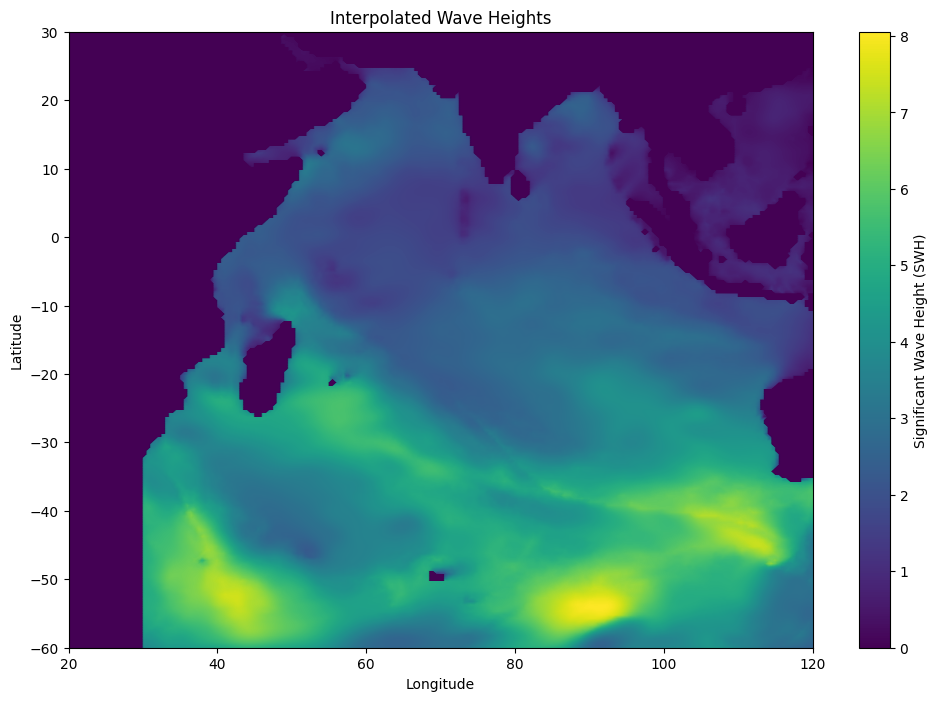

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 2.50458979 2.50374168 2.50289356]
 [0.         0.         0.         ... 2.5016727  2.49954724 2.49869913]
 [0.         0.         0.         ... 2.49875567 2.49663018 2.49450469]]
(4050, 4500)


In [6]:
# Load data
csv_path =  r"wave_data\time_data.csv"
data = pd.read_csv(csv_path)

# Interpolate
grid_lon, grid_lat, interpolated_grid = interpolate_wave_heights(data)
flipped_grid_data = np.flipud(interpolated_grid)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(grid_lon, grid_lat, 
                      c=interpolated_grid, 
                      cmap='viridis', 
                      s=1)  # smaller point size due to more points
plt.colorbar(scatter, label='Significant Wave Height (SWH)')
plt.title('Interpolated Wave Heights')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(20, 120)
plt.ylim(-60, 30)
plt.show()


print(flipped_grid_data)
print(flipped_grid_data.shape)

In [7]:
npy_file_path = "wave_height.npy"
np.save(npy_file_path, flipped_grid_data)
print(f"Flipped grid data saved to {npy_file_path}")

Flipped grid data saved to wave_height.npy


In [9]:
loaded_data = np.load("wave_height.npy")
print(loaded_data.shape)

(4050, 4500)


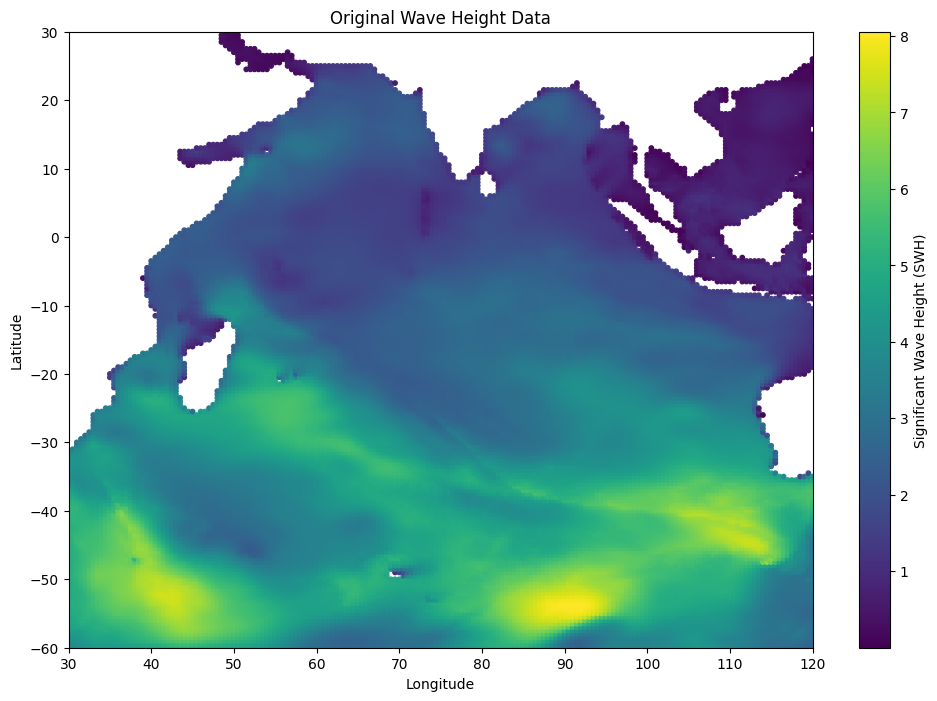

In [4]:
# Load data
data = pd.read_csv(csv_path)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data['LON'], data['LAT'], 
                      c=data['SWH'], 
                      cmap='viridis', 
                      s=10)  # size of points
plt.colorbar(scatter, label='Significant Wave Height (SWH)')
plt.title('Original Wave Height Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(30, 120)
plt.ylim(-60, 30)
plt.show()
    



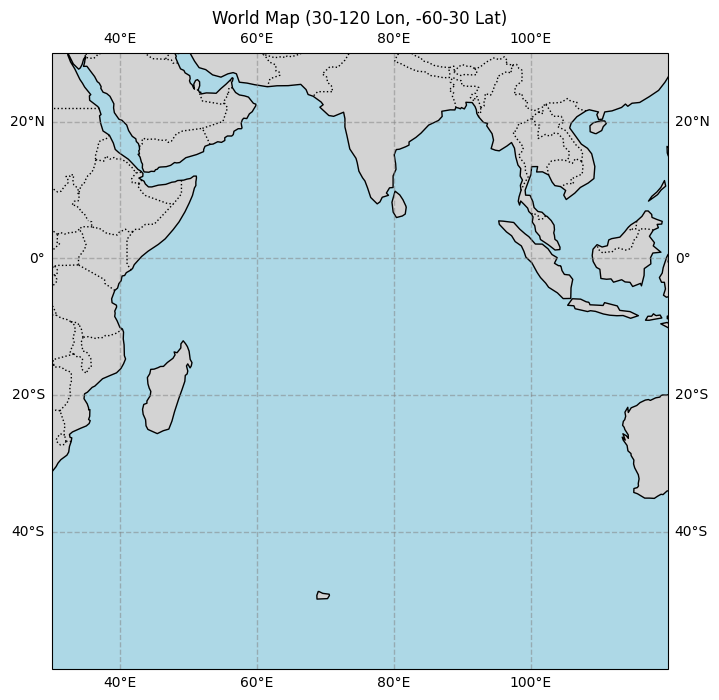

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_world_map():
    # Create a map projection
    fig, ax = plt.subplots(figsize=(12, 8), 
                            subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set map extent
    ax.set_extent([30, 120, -60, 30], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # Add gridlines
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', 
                 alpha=0.5, linestyle='--')
    
    plt.title('World Map (30-120 Lon, -60-30 Lat)')
    plt.show()

# Execute the plot
plot_world_map()

In [10]:
grid_lon_swell, grid_lat_swell, interpolated_grid_swell = interpolate_wave_heights(data,height_column = 'SWELL')

KeyboardInterrupt: 

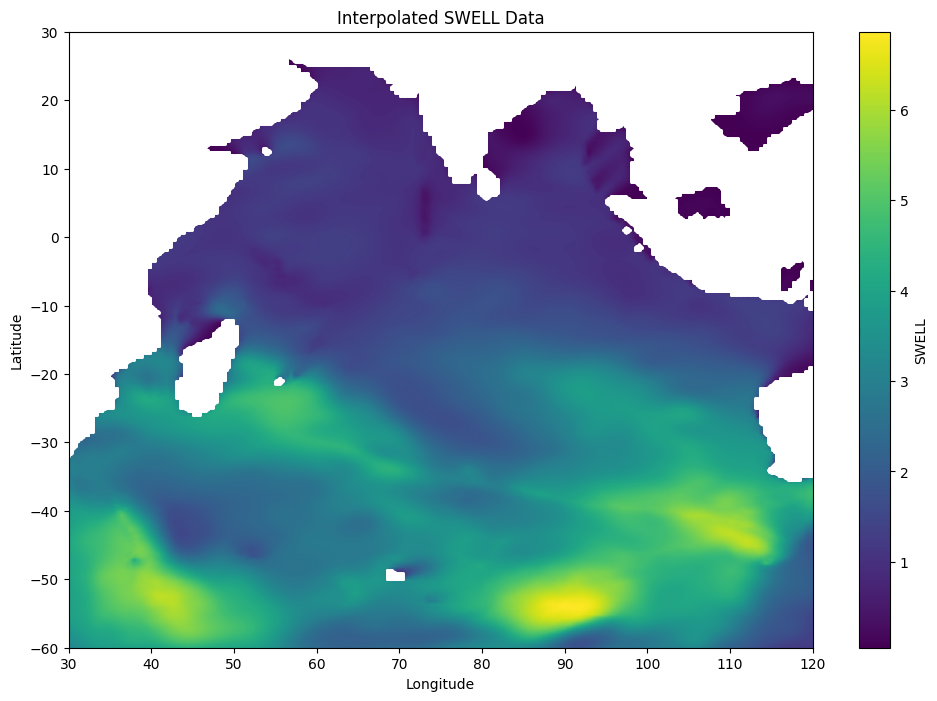

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [3.27811006 3.28089827 3.28368648 ... 1.2368437  1.23854981 1.24025592]
 [3.26753904 3.27032725 3.27557929 ... 1.23213091 1.23177117 1.23347728]
 [3.25696802 3.26222007 3.26747211 ... 1.22741813 1.22705838 1.22669864]]
(900, 900)


In [10]:
flipped_grid_data = np.flipud(interpolated_grid_swell)

# Mask for zero values
zero_mask = (interpolated_grid_swell == 0)

# Create a figure
plt.figure(figsize=(12, 8))

# Plot the main scatter plot with non-zero values
scatter = plt.scatter(
    grid_lon[~zero_mask], 
    grid_lat[~zero_mask], 
    c=interpolated_grid_swell[~zero_mask], 
    cmap='viridis', 
    s=1  # smaller point size due to more points
)

# Add a scatter plot for zero values in white
plt.scatter(
    grid_lon[zero_mask], 
    grid_lat[zero_mask], 
    c='white', 
    s=1  # smaller point size
)

# Add colorbar and labels
plt.colorbar(scatter, label='SWELL')
plt.title('Interpolated SWELL Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(30, 120)
plt.ylim(-60, 30)

# Show the plot
plt.show()

# Check flipped grid data and its shape
print(flipped_grid_data)
print(flipped_grid_data.shape)


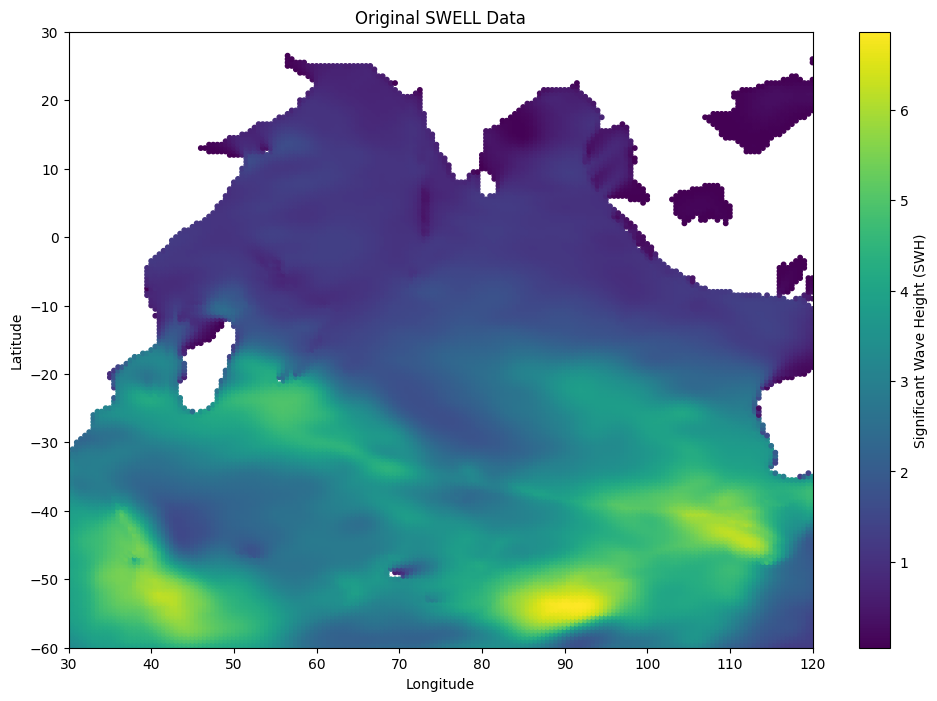

In [11]:
# Load data
data = pd.read_csv(csv_path)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data['LON'], data['LAT'], 
                      c=data['SWELL'], 
                      cmap='viridis', 
                      s=10)  # size of points
plt.colorbar(scatter, label='Significant Wave Height (SWH)')
plt.title('Original SWELL Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(30, 120)
plt.ylim(-60, 30)
plt.show()

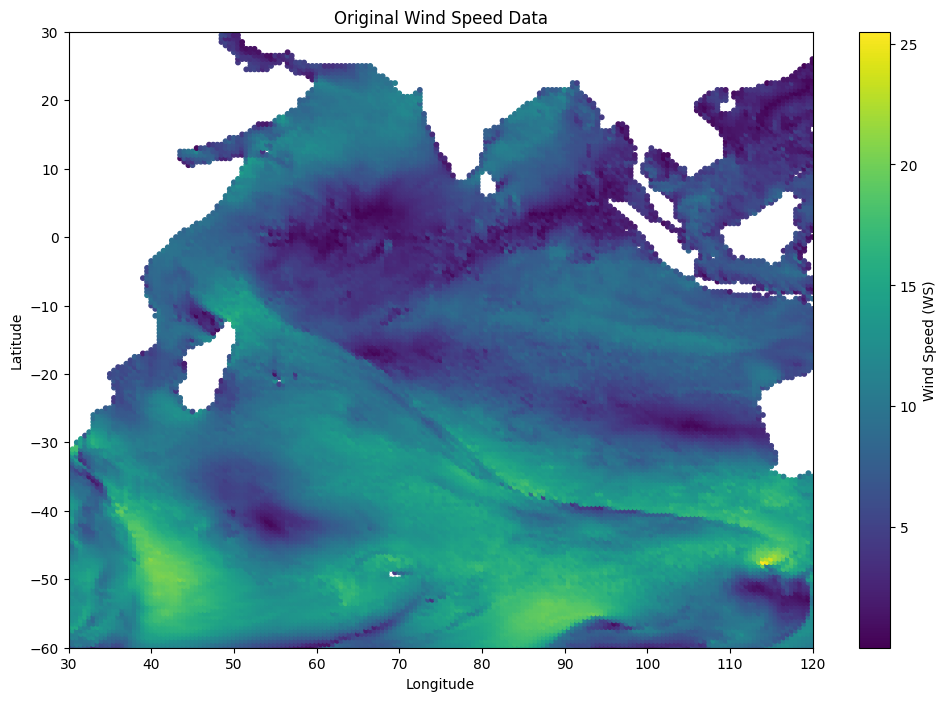

In [12]:
# Load data
import pandas as pd
csv_path = r"wave_data\time_data.csv"
data = pd.read_csv(csv_path)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data['LON'], data['LAT'], 
                      c=data['WS'], 
                      cmap='viridis', 
                      s=10)  # size of points
plt.colorbar(scatter, label='Wind Speed (WS)')
plt.title('Original Wind Speed Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(30, 120)
plt.ylim(-60, 30)
plt.show()

In [13]:
max_ws = data['WS'].max()
print(f"Maximum Wind Speed (WS): {max_ws}")

Maximum Wind Speed (WS): 25.487326735749505


In [11]:
grid_lon_ws, grid_lat_ws, interpolated_grid_ws = interpolate_wave_heights(data,(4050,4500),'WS')

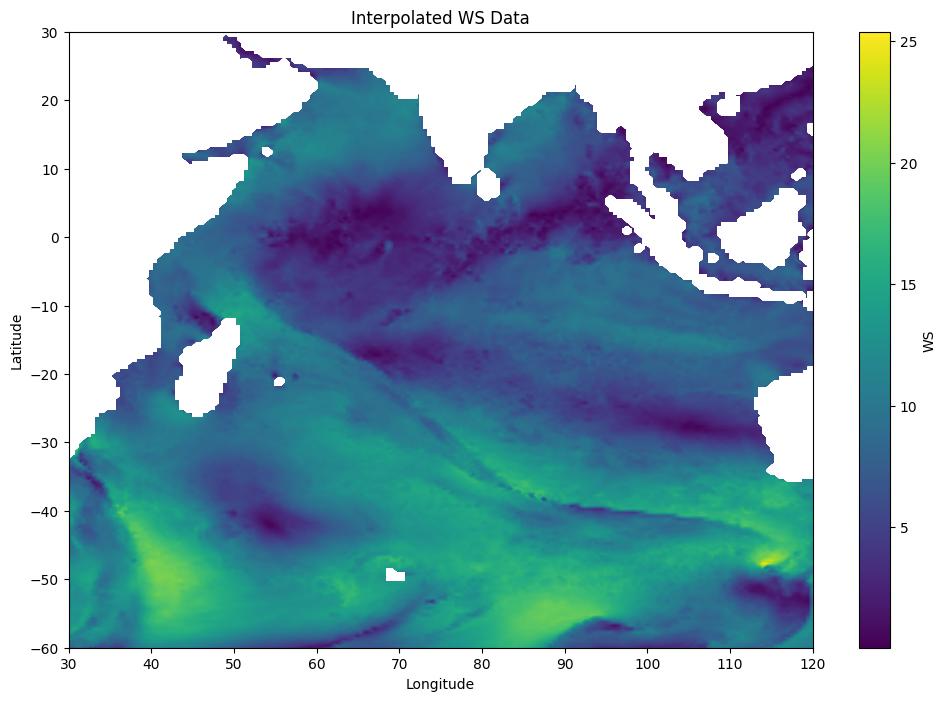

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 10.18622855 10.17946021
  10.17269186]
 [ 0.          0.          0.         ... 10.15968276 10.15498417
  10.14821582]
 [ 0.          0.          0.         ... 10.13313686 10.12843832
  10.12373979]]
(4050, 4500)


In [12]:
wind_speed_grid = np.flipud(interpolated_grid_ws)



# Mask for zero values
zero_mask = (interpolated_grid_ws == 0)

# Create a figure
plt.figure(figsize=(12, 8))

# Plot the main scatter plot with non-zero values
scatter = plt.scatter(
    grid_lon[~zero_mask], 
    grid_lat[~zero_mask], 
    c=interpolated_grid_ws[~zero_mask], 
    cmap='viridis', 
    s=1  # smaller point size due to more points
)

# Add a scatter plot for zero values in white
plt.scatter(
    grid_lon_ws[zero_mask], 
    grid_lat_ws[zero_mask], 
    c='white', 
    s=1  # smaller point size
)

# Add colorbar and labels
plt.colorbar(scatter, label='WS')
plt.title('Interpolated WS Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(30, 120)
plt.ylim(-60, 30)

# Show the plot
plt.show()

# Check flipped grid data and its shape
print(wind_speed_grid)
print(wind_speed_grid.shape)


In [13]:
npy_file_path = "wind_speed_data.npy"
np.save(npy_file_path, wind_speed_grid)
print(f"Flipped grid data saved to {npy_file_path}")

Flipped grid data saved to wind_speed_data.npy


In [14]:
loaded_data = np.load("wind_speed_data.npy")
print(loaded_data)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 10.18622855 10.17946021
  10.17269186]
 [ 0.          0.          0.         ... 10.15968276 10.15498417
  10.14821582]
 [ 0.          0.          0.         ... 10.13313686 10.12843832
  10.12373979]]


In [ ]:
import numpy as np
from scipy.interpolate import griddata

def interpolate_wind_directions(original_data, grid_size=900, direction_column='WINDDIR'):
    """
    Interpolates wind direction data to a finer grid while accounting for circular nature.

    Args:
        original_data (pd.DataFrame): DataFrame containing 'LON', 'LAT', and wind direction column.
        grid_size (int): The resolution of the interpolation grid.
        direction_column (str): Name of the column containing wind direction in degrees.

    Returns:
        tuple: grid_lon, grid_lat, interpolated_wind_directions
    """
    # Extract points and wind directions
    points = original_data[['LON', 'LAT']].values
    wind_directions = original_data[direction_column].values

    # Convert wind directions to radians
    wind_directions_rad = np.deg2rad(wind_directions)

    # Decompose into vector components
    u = np.cos(wind_directions_rad)
    v = np.sin(wind_directions_rad)

    # Define the interpolation grid
    lon_min, lon_max = 30, 120
    lat_min, lat_max = -60, 30
    lon_grid = np.linspace(lon_min, lon_max, grid_size)
    lat_grid = np.linspace(lat_min, lat_max, grid_size)
    grid_lon, grid_lat = np.meshgrid(lon_grid, lat_grid)

    # Interpolate vector components
    grid_u = griddata(points, u, (grid_lon, grid_lat), method='linear')
    grid_v = griddata(points, v, (grid_lon, grid_lat), method='linear')

    # Replace NaNs with zeros to handle missing data
    grid_u = np.nan_to_num(grid_u, nan=0)
    grid_v = np.nan_to_num(grid_v, nan=0)

    # Reconstruct wind directions from interpolated components
    grid_wind_directions_rad = np.arctan2(grid_v, grid_u)
    grid_wind_directions = np.rad2deg(grid_wind_directions_rad)

    # Normalize to [0, 360) range
    grid_wind_directions = (grid_wind_directions + 360) % 360

    return grid_lon, grid_lat, grid_wind_directions


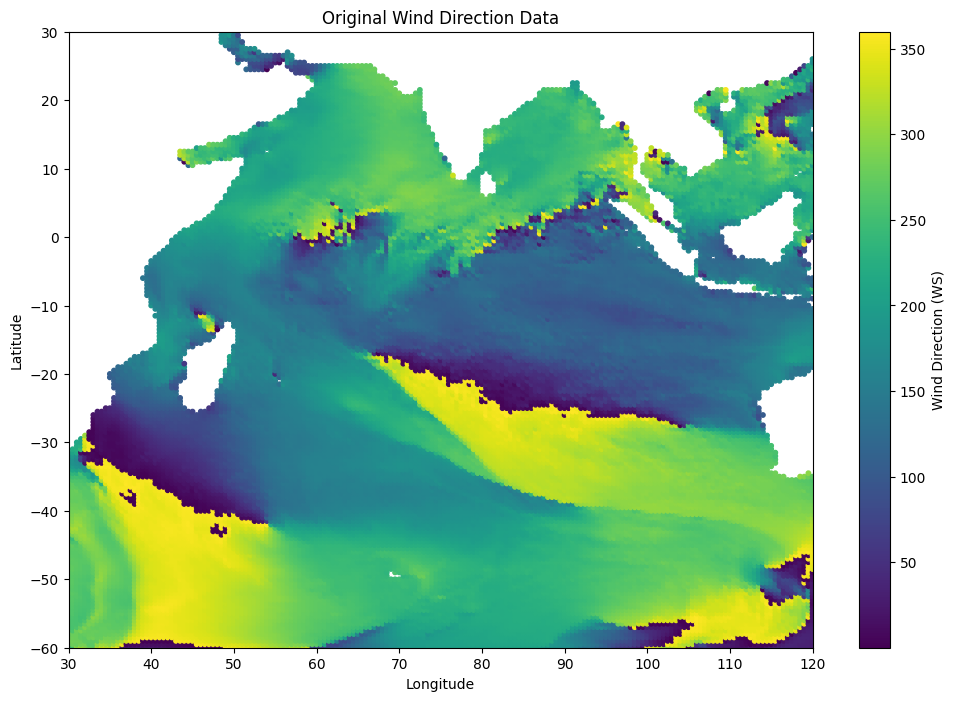

In [3]:
# Load data
import pandas as pd
csv_path = r"wave_data\time_data.csv"
data = pd.read_csv(csv_path)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data['LON'], data['LAT'], 
                      c=data['WINDDIR'], 
                      cmap='viridis', 
                      s=10)  # size of points
plt.colorbar(scatter, label='Wind Direction (WS)')
plt.title('Original Wind Direction Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(30, 120)
plt.ylim(-60, 30)
plt.show()

In [4]:
grid_lon_wdir, grid_lat_wdir, interpolated_grid_wdir = interpolate_wind_directions(data,(4050,4500),'WINDDIR')

[[285.30976215 278.43767279 271.23647654 ...  31.97931767  31.64142605
   31.30356961]
 [284.56953075 284.10752279 277.20242464 ...  31.92237974  31.58449651
   31.15813983]
 [283.82892896 283.36650123 282.90369366 ...  31.86544364  31.43906421
   31.01270725]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


In [5]:
wind_dir_grid = np.flipud(interpolated_grid_wdir)



# Mask for zero values
zero_mask = (interpolated_grid_wdir == 0)

# Create a figure
plt.figure(figsize=(12, 8))

# Plot the main scatter plot with non-zero values
scatter = plt.scatter(
    grid_lon[~zero_mask], 
    grid_lat[~zero_mask], 
    c=interpolated_grid_wdir[~zero_mask], 
    cmap='viridis', 
    s=1  # smaller point size due to more points
)

# Add a scatter plot for zero values in white
plt.scatter(
    grid_lon_ws[zero_mask], 
    grid_lat_ws[zero_mask], 
    c='white', 
    s=1  # smaller point size
)

# Add colorbar and labels
plt.colorbar(scatter, label='WS')
plt.title('Interpolated WS Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(30, 120)
plt.ylim(-60, 30)

# Show the plot
plt.show()

# Check flipped grid data and its shape
print(wind_dir_grid)
print(wind_dir_grid.shape)


NameError: name 'grid_lon' is not defined

<Figure size 1200x800 with 0 Axes>

In [6]:
npy_file_path = "wind_dir_data.npy"
np.save(npy_file_path, wind_dir_grid)
print(f"Flipped grid data saved to {npy_file_path}")

Flipped grid data saved to wind_dir_data.npy
